In [1]:
import rasterio
from rasterio import merge
from rasterio.warp import calculate_default_transform, reproject, Resampling

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors

import xarray as xr

# UK CEH land cover

The UK Centre for Ecology and Hydrology Land Cover maps https://www.ceh.ac.uk/data/ukceh-land-cover-maps use satellite image to create a contiguous land use map of the UK classifiying land into 21 target categories:

1. Broadleaved woodland
2. Coniferous woodland
3. Arable
4. Improved grassland
5. Neutral grassland
6. Calcareous grassland
7. Acid grassland
8. Fen, Marsh and Swamp
9. Heather and shrub
10. Heather grassland
11. Bog
12. Inland rock
13. Saltwater
14. Freshwater
15. Supralittoral rock
16. Supralittoral sediment
17. Littoral rock
18. Littoral sediment
19. Saltmarsh
20. Urban
21. Suburban

Additionally, 10 aggregate categories are defined

1. Broadleaf woodland
2. Coniferous woodland
3. Arable
4. Improved grassland
5. Semi-natural grassland
6. Mountain, heath and bog
7. Saltwater
8. Freshwater
9. Coastal
10. Built-up areas and gardens


1000m rasterised data can be downloaded from https://catalogue.ceh.ac.uk/documents/a3ff9411-3a7a-47e1-9b3e-79f21648237d.
The dataset contains 2 sets of 4 separate files. Including dominant class and class percentages for each set of classes, and for Great Britain and Norther Ireland in separate files.

In this notebook we plot the different UK datasets and store them into a NetCDF file for use in the AgriFoodPy package.

In [2]:
aggregate_names=[
    "Broadleaf woodland",
    "Coniferous woodland",
    "Arable",
    "Improved grassland",
    "Semi-natural grassland",
    "Mountain, heath and bog",
    "Saltwater",
    "Freshwater",
    "Coastal",
    "Built-up areas and gardens"
]

target_names=[
    "Broadleaved woodland",
    "Coniferous woodland",
    "Arable",
    "Improved grassland",
    "Neutral grassland",
    "Calcareous grassland",
    "Acid grassland",
    "Fen, Marsh and Swamp",
    "Heather and shrub",
    "Heather grassland",
    "Bog",
    "Inland rock",
    "Saltwater",
    "Freshwater",
    "Supralittoral rock",
    "Supralittoral sediment",
    "Littoral rock",
    "Littoral sediment",
    "Saltmarsh",
    "Urban",
    "Suburban"
]

# Dominant dataset

In [3]:
# Merge datasets into a single array

# First convert NI and GB datasets to British National Grid

# dominant_target
dst_crs = 'EPSG:27700'
data_path = "../../../data/land/CEH/a3ff9411-3a7a-47e1-9b3e-79f21648237d/data/"
inputs_dominant_target = ['gb2021lcm1km_dominant_target.tif',
                          'ni2021lcm1km_dominant_target.tif']

for inp in inputs_dominant_target:
    with rasterio.open(data_path+inp) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(data_path + "output_" + inp, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)


In [4]:
# Dominant_aggregate
inputs_dominant_aggregate = ['gb2021lcm1km_dominant_aggregate.tif', 'ni2021lcm1km_dominant_aggregate.tif']

for inp in inputs_dominant_aggregate:
    with rasterio.open(data_path + inp) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(data_path + "output_" + inp, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

In [5]:
# Merge Datasets

# Dominant_target
dominant_target_gb = rasterio.open(data_path + "output_gb2021lcm1km_dominant_target.tif")
dominant_target_ni = rasterio.open(data_path + "output_ni2021lcm1km_dominant_target.tif")

imarray_dom_tar, aff = merge.merge([dominant_target_gb, dominant_target_ni])
imarray_dom_tar = imarray_dom_tar[0]

# Dominant_target
dominant_aggregate_gb = rasterio.open(data_path + "output_gb2021lcm1km_dominant_aggregate.tif")
dominant_aggregate_ni = rasterio.open(data_path + "output_ni2021lcm1km_dominant_aggregate.tif")

imarray_dom_agg, aff = merge.merge([dominant_aggregate_gb, dominant_aggregate_ni])
imarray_dom_agg = imarray_dom_agg[0]

In [6]:
# make a color map of fixed colors
# list of indexes               1,2        3        4,5       6      7,8,9    10
cmap_agg = colors.ListedColormap(['green', 'orange', 'yellow', 'brown', 'blue', 'grey'])
bounds_agg=                    [0,      2.5,      3.5,      5.5,     6.5,    9.5,      11]
norm_agg = colors.BoundaryNorm(bounds_agg, cmap_agg.N)

In [7]:
color_list = ["#ff0000", "#006600", "#732600", "#00ff00", 
"#7fe57f", "#70a800", "#998100", "#ffff00",
"#801a80", "#e68ca6", "#008073", "#d2d2ff",
"#000080", "#0000ff", "#ccb300", "#ccb300",
"#ffff80", "#ffff80", "#8080ff", "#000000",
"#808080"]

cb_color_list = ["#33a02c", "#005000", "#f0e442", "#01ff7c",
"#dc9909", "#ffc037", "#b29100", "#fd7bee",
"#801a80", "#e68ca6", "#cd3bb5", "#d2d2ff",
"#00005c", "#0000ff", "#987db7", "#ccb300",
"#ffff80", "#ffff80", "#8080ff", "#000000",
"#808080"]

# make a color map of fixed colors
cmap_tar = colors.ListedColormap(color_list)
bounds_tar = np.linspace(0.5, 21.5, 22)
norm_tar = colors.BoundaryNorm(bounds_tar, cmap_tar.N)

Text(0.5, 1.0, 'dominant target')

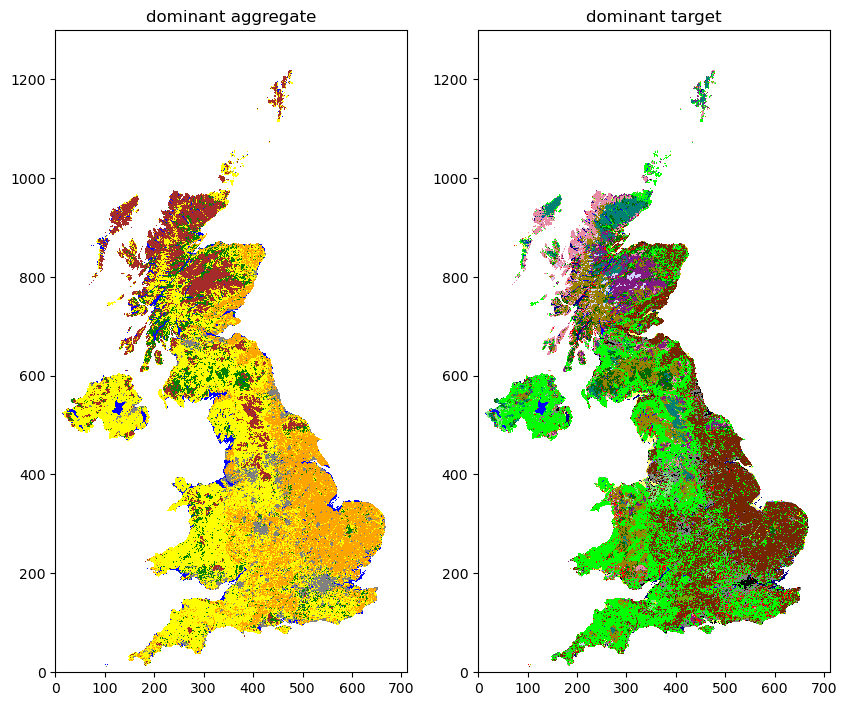

In [8]:
imarray_dom_agg = np.flip(imarray_dom_agg, axis=0).astype(float)
imarray_dom_tar = np.flip(imarray_dom_tar, axis=0).astype(float)

nan_mask = np.where(imarray_dom_agg == 0)
imarray_dom_agg[nan_mask] = np.NaN
imarray_dom_tar[nan_mask] = np.NaN

f, axs = plt.subplots(1, 2, figsize=(10,12))
axs[0].imshow(imarray_dom_agg, interpolation="none", cmap=cmap_agg, norm=norm_agg, origin="lower")
axs[0].set_title("dominant aggregate")

axs[1].imshow(imarray_dom_tar, interpolation="none", cmap=cmap_tar, norm=norm_tar, origin="lower")
axs[1].set_title("dominant target")

In [9]:
size = imarray_dom_agg.shape

xpos = np.arange(size[0]+1)*1000
ypos = np.arange(size[1]+1)*1000

xcoords = 0.5*(ypos[1:] + ypos[:-1])
ycoords = 0.5*(xpos[1:] + xpos[:-1])

# Percentage dataset

In [10]:
# Merge datasets into a single array

# First convert NI and GB datasets to British National Grid

# percentage_target
dst_crs = 'EPSG:27700'
data_path = "../../../data/land/CEH/a3ff9411-3a7a-47e1-9b3e-79f21648237d/data/"
inputs_percentage_target = ['gb2021lcm1km_percentage_target.tif',
                            'ni2021lcm1km_percentage_target.tif']

for inp in inputs_percentage_target:
    with rasterio.open(data_path+inp) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(data_path + "output_" + inp, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

In [11]:
# percentage_aggregate
inputs_percentage_aggregate = ['gb2021lcm1km_percentage_aggregate.tif',
                               'ni2021lcm1km_percentage_aggregate.tif']

for inp in inputs_percentage_aggregate:
    with rasterio.open(data_path + inp) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(data_path + "output_" + inp, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

In [12]:
# Merge Datasets

# Percentage_target
percentage_target_gb = rasterio.open(data_path + "output_gb2021lcm1km_percentage_target.tif")
percentage_target_ni = rasterio.open(data_path + "output_ni2021lcm1km_percentage_target.tif")

imarray_per_tar, aff = merge.merge([percentage_target_gb, percentage_target_ni])
imarray_per_tar = imarray_per_tar.astype('float32')

# Percentage_target
percentage_aggregate_gb = rasterio.open(data_path + "output_gb2021lcm1km_percentage_aggregate.tif")
percentage_aggregate_ni = rasterio.open(data_path + "output_ni2021lcm1km_percentage_aggregate.tif")

imarray_per_agg, aff = merge.merge([percentage_aggregate_gb, percentage_aggregate_ni])
imarray_per_agg = imarray_per_agg.astype('float32')

In [13]:
imarray_per_agg = np.flip(imarray_per_agg, axis=1)
imarray_per_tar = np.flip(imarray_per_tar, axis=1)

for i in range(10):
    imarray_per_agg[i][nan_mask] = np.NaN

for i in range(21):
    imarray_per_tar[i][nan_mask] = np.NaN


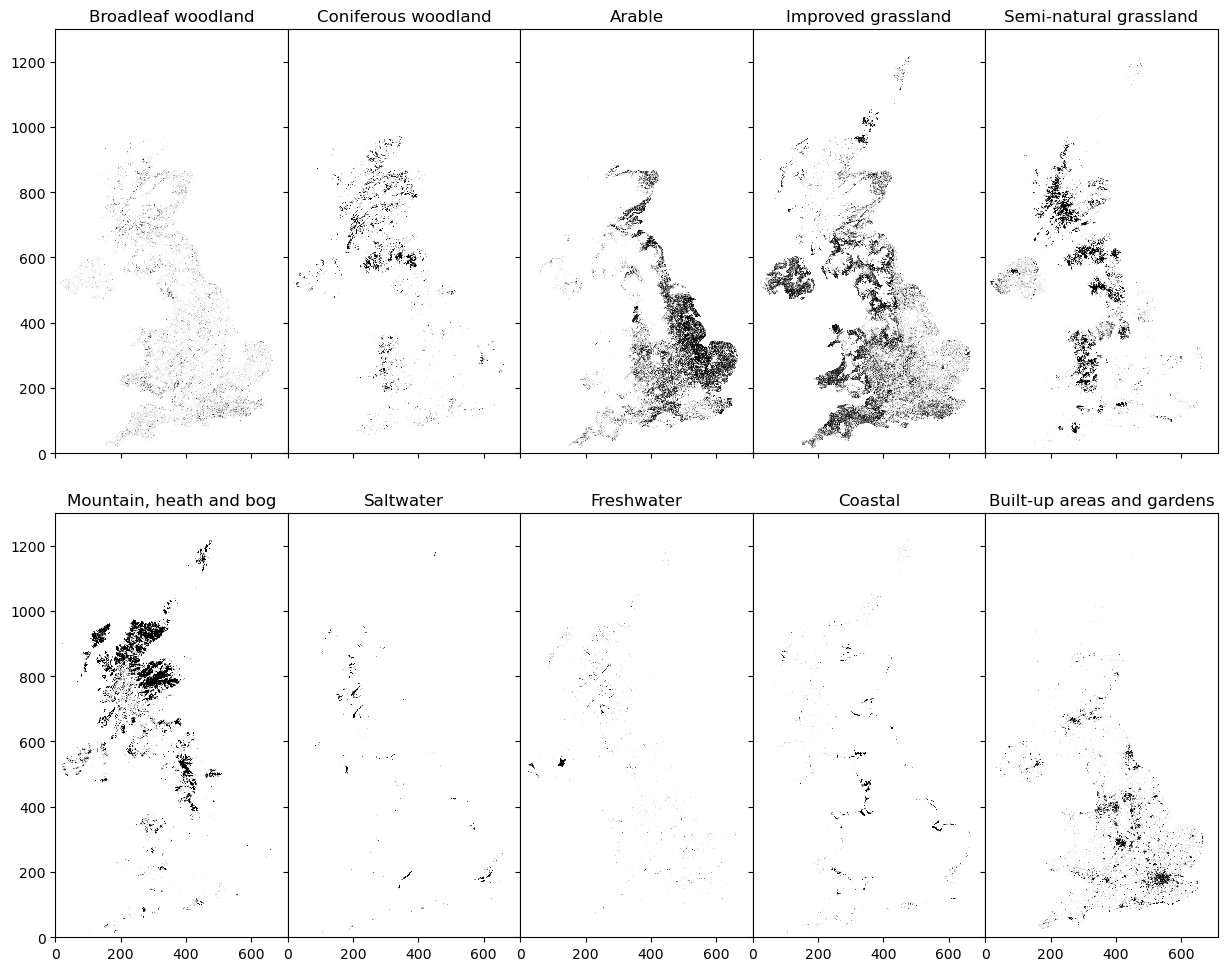

In [14]:
# plt.figure(figsize=(10,12))
f, axs = plt.subplots(2, 5, figsize=(15,12), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.1, wspace=0)

for i, ax in enumerate(np.ravel(axs)):
    ax.imshow(imarray_per_agg[i], interpolation="none", cmap="Greys", origin="lower")
    ax.set_title(aggregate_names[i])

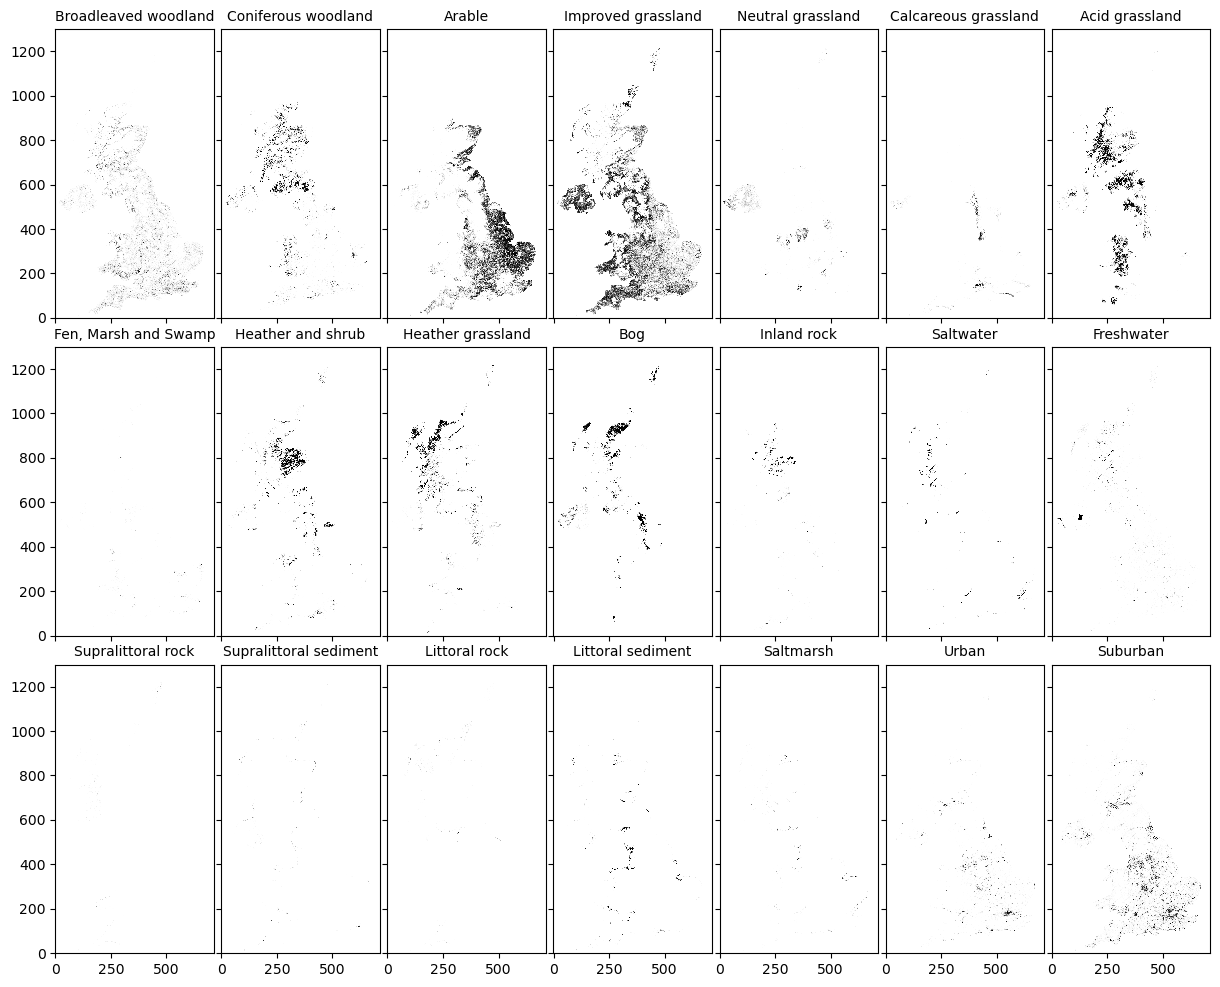

In [15]:
# plt.figure(figsize=(10,12))
f, axs = plt.subplots(3, 7, figsize=(15,12), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.1, wspace=0)

for i, ax in enumerate(np.ravel(axs)):
    ax.imshow(imarray_per_tar[i], interpolation="none", cmap="Greys", origin="lower")
    ax.set_title(target_names[i], size=10)

In [16]:
# Create xaarray dataset

data = xr.Dataset(
    data_vars = dict(
        dominant_target=(["y", "x"], imarray_dom_tar),
        dominant_aggregate=(["y", "x"], imarray_dom_agg),
        percentage_target=(["target_class", "y", "x"], imarray_per_tar),
        percentage_aggregate=(["aggregate_class", "y", "x"], imarray_per_agg),
    ),
    coords = dict(
        y=("y", ycoords),
        x=("x", xcoords),
        target_class=("target_class", target_names),
        aggregate_class=("aggregate_class", aggregate_names)
    )
)
data

<xarray.Dataset>
Dimensions:               (y: 1300, x: 713, target_class: 21,
                           aggregate_class: 10)
Coordinates:
  * y                     (y) float64 500.0 1.5e+03 ... 1.298e+06 1.3e+06
  * x                     (x) float64 500.0 1.5e+03 ... 7.115e+05 7.125e+05
  * target_class          (target_class) <U22 'Broadleaved woodland' ... 'Sub...
  * aggregate_class       (aggregate_class) <U26 'Broadleaf woodland' ... 'Bu...
Data variables:
    dominant_target       (y, x) float64 nan nan nan nan nan ... nan nan nan nan
    dominant_aggregate    (y, x) float64 nan nan nan nan nan ... nan nan nan nan
    percentage_target     (target_class, y, x) float32 nan nan nan ... nan nan
    percentage_aggregate  (aggregate_class, y, x) float32 nan nan ... nan nan

In [17]:
encoding = {"dominant_target":{"dtype":"float32", "zlib": True, "complevel": 5},
            "dominant_aggregate":{"dtype":"float32", "zlib": True, "complevel": 5},
            "percentage_target":{"dtype":"float32", "zlib": True, "complevel": 5},
            "percentage_aggregate":{"dtype":"float32", "zlib": True, "complevel": 5}}

data.to_netcdf(f"../data/UKCEH_LC_1000.nc", encoding=encoding)